# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face Mask Segmentation
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [3]:
from google.colab import drive
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import tensorflow
import os
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(0)
%matplotlib inline
drive.mount('/content/drive', force_remount=True)
tensorflow.test.gpu_device_name()

Mounted at /content/drive


'/device:GPU:0'

### Change current working directory to project folder (1 mark)

In [7]:
path = os.chdir('/content/drive/My Drive/assignments/Facemask')

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [8]:
data = np.load('./images.npy', allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)
Hint - print data[10][1] 

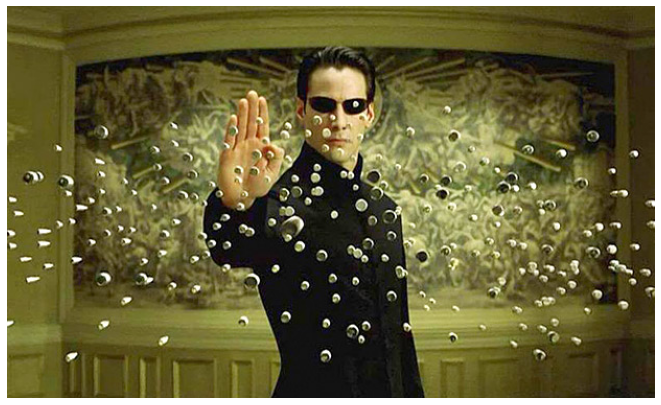

In [33]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')

# printing an image from the dataset
plt.imshow(data[66][0])
plt.show()

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [10]:
#  setting image width and height values
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [11]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (2 marks)

In [12]:
#  Printing th shape X_train
X_train.shape

(409, 224, 224, 3)

In [13]:
#  Printing the mask shape
masks.shape

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.28627449 -0.34117645 -0.77254903]
  [-0.29411763 -0.34901959 -0.78039217]
  [-0.30196077 -0.35686272 -0.78823531]
  ...
  [-0.41176468 -0.48235291 -0.83529413]
  [-0.41176468 -0.48235291 -0.84313726]
  [-0.40392154 -0.49019605 -0.85882354]]

 [[-0.24705881 -0.30196077 -0.73333335]
  [-0.27843136 -0.33333331 -0.7647059 ]
  [-0.26274508 -0.31764704 -0.74901962]
  ...
  [-0.43529409 -0.49803919 -0.85882354]
  [-0.44313723 -0.51372552 -0.88235295]
  [-0.42745095 -0.50588238 -0.89019608]]

 [[-0.27843136 -0.33333331 -0.7647059 ]
  [-0.25490195 -0.3098039  -0.74117649]
  [-0.20784312 -0.26274508 -0.7019608 ]
  ...
  [-0.45098037 -0.51372552 -0.87450981]
  [-0.45098037 -0.52156866 -0.89803922]
  [-0.44313723 -0.52156866 -0.9137255 ]]

 ...

 [[-0.09019607 -0.12156862 -0.69411767]
  [-0.09803921 -0.12941176 -0.7019608 ]
  [-0.13725489 -0.16862744 -0.74117649]
  ...
  [-0.74117649 -0.78823531 -0.89019608]
  [-0.72549021 -0.77254903 -0.86666667]
  [-0.74901962 -0.79607844 -0.89803922]]

 [

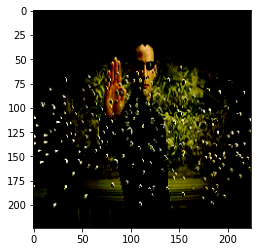

In [15]:
#  Printing a sample image from the train set
from matplotlib import pyplot
n = 66
print(X_train[n])
pyplot.imshow(X_train[n])

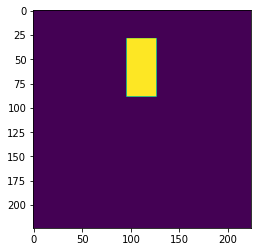

In [16]:
# Printing the image from the y set
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [17]:
#  Model Creation
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
ALPHA = 1
IMAGE_SIZE = 224

def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = ALPHA, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output
    
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return tensorflow.keras.Model(inputs = model.input, outputs = x)

### Call the create_model function

In [18]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________________________

### Define dice coefficient function (10 marks)
- Create a function to calculate dice coefficient


In [19]:
# Define dice coefficient function
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

### Define loss

In [20]:
#  Defining loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (3 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [21]:
#  Compiling the model
from tensorflow.keras.optimizers import Adam
adam = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])

### Define checkpoint and earlystopping

In [22]:
#  Defining early stopping
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (3 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [23]:
#  Fit the model
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, masks, test_size = 0.15, random_state = 2019, shuffle = False)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

model.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_valid, y_valid))

Epoch 1/30
347/347 [==============================] - ETA: 0s - loss: 1.3964 - dice_coefficient: 0.4187
Epoch 00001: loss improved from inf to 1.39638, saving model to model-1.40.h5
347/347 [==============================] - 32s 94ms/step - loss: 1.3964 - dice_coefficient: 0.4187 - val_loss: 1.1501 - val_dice_coefficient: 0.4494 - lr: 1.0000e-04
Epoch 2/30
347/347 [==============================] - ETA: 0s - loss: 0.9859 - dice_coefficient: 0.5312
Epoch 00002: loss improved from 1.39638 to 0.98590, saving model to model-0.99.h5
347/347 [==============================] - 31s 91ms/step - loss: 0.9859 - dice_coefficient: 0.5312 - val_loss: 1.1035 - val_dice_coefficient: 0.4538 - lr: 1.0000e-04
Epoch 3/30
347/347 [==============================] - ETA: 0s - loss: 0.7646 - dice_coefficient: 0.6129
Epoch 00003: loss improved from 0.98590 to 0.76456, saving model to model-0.76.h5
347/347 [==============================] - 32s 91ms/step - loss: 0.7646 - dice_coefficient: 0.6129 - val_loss: 0.9

In [24]:
# Evaluation
# Load previous model weight
WEIGHTS_FILE = "model-0.11.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)
y_pred = learned_model.predict(X_valid, verbose = 1)

2/2 [==============================] - 4s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


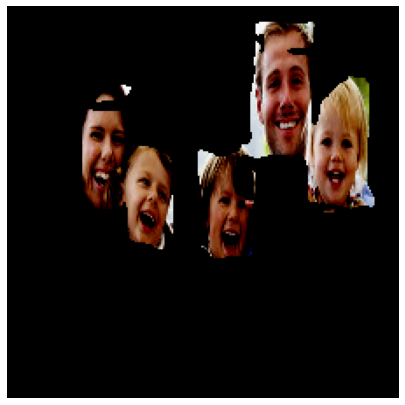

In [31]:
# For a sample image
n = 18
image = cv2.resize(X_valid[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0*(y_pred[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]
out_image = image2

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

### Get the predicted mask for a sample image   (5 marks)

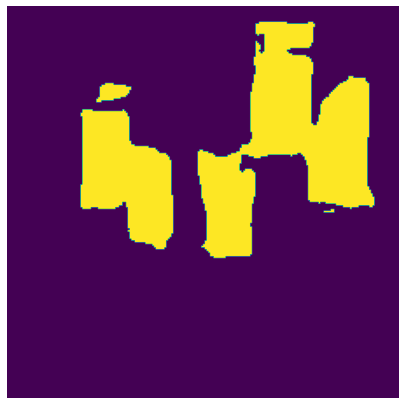

In [34]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)

### Impose the mask on the image (5 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


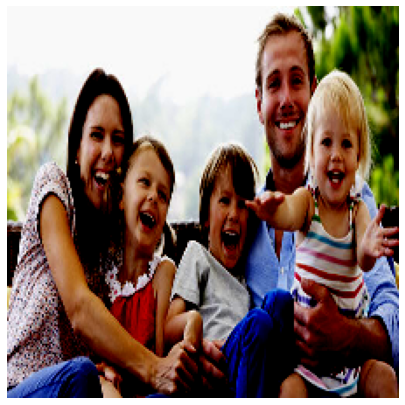

In [35]:
# imposing on to image
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_valid[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

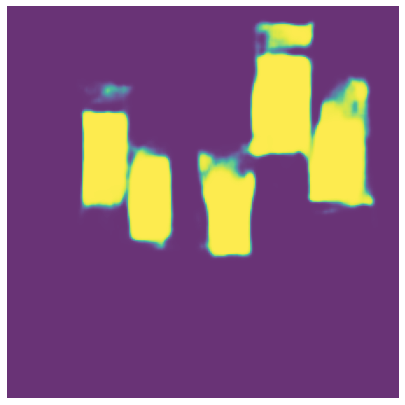

In [36]:

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(y_pred[n], alpha = 0.8)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

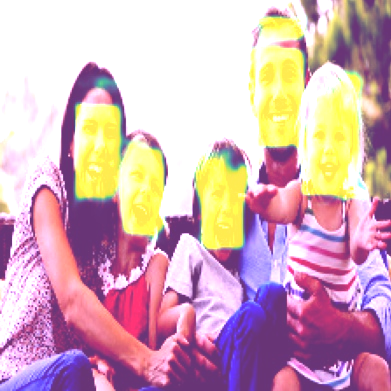

In [37]:

from google.colab.patches import cv2_imshow
img = cv2.imread('image.jpg', 1)
mask = cv2.imread('mask.jpg', 1)
img = cv2.add(img, mask)
cv2_imshow(img)

Conclusion

In [38]:
# Model was complied using binary cross entropy as loss, adam optimizer and dice coefficient as metrics.
# Model weights for this were used and then used to predict on validation data to get mask.
# As seen in the above images, it can be seen that model does a very good job in predicting the masks.